In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-04-03 21:50:15.282462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 21:50:15.399869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 21:50:15.399886: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 21:50:16.142482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Se leen los archivos



In [3]:
# file = '/home/isidro/Documents/github/SNIa_ML_regressions/data/pantheon.txt'
file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon.txt'
syscov_file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon_errors.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ", usecols=['zcmb', 'mb', 'dmb'])
# df = pd.read_csv(file, sep = " ")
dmag = df[['dmb']]
df = df[['zcmb', 'mb']]
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [4]:
df.head()

,zcmb,mb
0,0.50349,22.93445
1,0.49520,22.88020
2,0.67820,24.03770
3,0.86720,24.34685
4,0.79920,24.36050


In [5]:
dmag = dmag.values.reshape(N,)
np.shape(dmag)

(1048,)

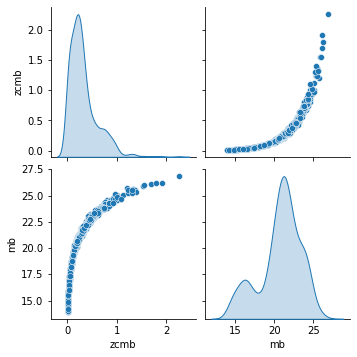

In [6]:
sns.pairplot(df, diag_kind="kde")

In [7]:
np.shape(dmag), np.shape(cov)
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1045, 1046, 1047]),
 array([   0,    1,    2, ..., 1045, 1046, 1047]))

In [8]:
cov[np.diag_indices_from(cov)] += dmag**2

In [9]:
sq_errors = np.diag(syscov)
print(np.shape(sq_errors), type(sq_errors))

(1048,) <class 'numpy.ndarray'>


In [10]:
df['errors'] = np.sqrt(sq_errors+dmag**2)
df.head()

,zcmb,mb,errors
0,0.50349,22.93445,0.126758
1,0.49520,22.88020,0.118172
2,0.67820,24.03770,0.206020
3,0.86720,24.34685,0.174903
4,0.79920,24.36050,0.175347


In [11]:
# df['mb'] += 19.36

(0.0, 2.3)

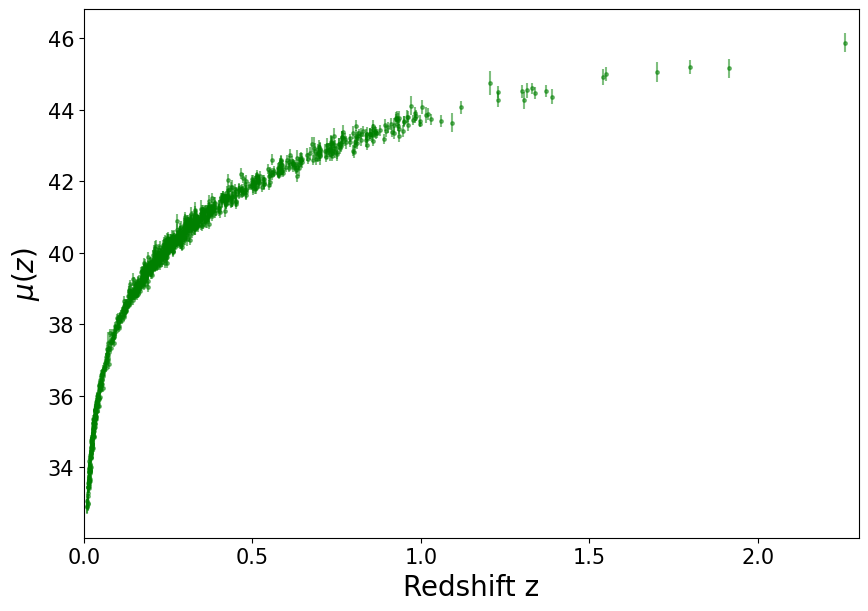

In [12]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)

In [13]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [14]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [15]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [16]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [18]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

#### Ahora usando incertidumbres de la red con Monte Carlo Dropout

In [19]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((838, 1), (838, 1), (210, 1), (210, 1))

In [20]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 50, 200])
model.summary()

2023-04-03 21:50:18.617355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-03 21:50:18.617383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-PC
2023-04-03 21:50:18.617389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-PC
2023-04-03 21:50:18.617503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.89.2
2023-04-03 21:50:18.617523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.89.2
2023-04-03 21:50:18.617528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.89.2
2023-04-03 21:50:18.618273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 MCDropout_2 (MCDropout)     (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4

In [21]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1200,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/1200
210/210 [==============================] - 1s 2ms/step - loss: 62.5471 - val_loss: 10.5507
Epoch 2/1200
210/210 [==============================] - 0s 1ms/step - loss: 7.6181 - val_loss: 8.8063
Epoch 3/1200
210/210 [==============================] - 0s 1ms/step - loss: 6.0786 - val_loss: 5.5634
Epoch 4/1200
210/210 [==============================] - 0s 1ms/step - loss: 5.1642 - val_loss: 5.3639
Epoch 5/1200
210/210 [==============================] - 0s 1ms/step - loss: 4.5615 - val_loss: 5.1113
Epoch 6/1200
210/210 [==============================] - 0s 1ms/step - loss: 4.2933 - val_loss: 4.2057
Epoch 7/1200
210/210 [==============================] - 0s 1ms/step - loss: 4.4701 - val_loss: 3.7181
Epoch 8/1200
210/210 [==============================] - 0s 1ms/step - loss: 3.4553 - val_loss: 3.3965
Epoch 9/1200
210/210 [==============================] - 0s 1ms/step - loss: 3.2920 - val_loss: 4.7750
Epoch 10/1200
210/210 [==============================] - 0s 1ms/step - loss: 3.0

210/210 [==============================] - 0s 1ms/step - loss: 0.9335 - val_loss: 0.6523
Epoch 81/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7889 - val_loss: 1.0560
Epoch 82/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8471 - val_loss: 0.8737
Epoch 83/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8645 - val_loss: 0.9563
Epoch 84/1200
210/210 [==============================] - 0s 1ms/step - loss: 1.0036 - val_loss: 0.9575
Epoch 85/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8806 - val_loss: 0.8259
Epoch 86/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8955 - val_loss: 0.9012
Epoch 87/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8124 - val_loss: 0.7191
Epoch 88/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.9024 - val_loss: 0.7696
Epoch 89/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.8443 - v

210/210 [==============================] - 0s 1ms/step - loss: 0.8076 - val_loss: 0.7087
Epoch 160/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7157 - val_loss: 0.5916
Epoch 161/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7633 - val_loss: 0.6574
Epoch 162/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7465 - val_loss: 0.8143
Epoch 163/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7073 - val_loss: 0.6608
Epoch 164/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7083 - val_loss: 0.6400
Epoch 165/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.7377 - val_loss: 0.8412
Epoch 166/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6351 - val_loss: 0.8124
Epoch 167/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6787 - val_loss: 0.7972
Epoch 168/1200
210/210 [==============================] - 0s 1ms/step - loss: 0

Epoch 238/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5750 - val_loss: 0.6642
Epoch 239/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6203 - val_loss: 0.6723
Epoch 240/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6153 - val_loss: 0.5981
Epoch 241/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5784 - val_loss: 0.5771
Epoch 242/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6027 - val_loss: 0.6328
Epoch 243/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6159 - val_loss: 0.6018
Epoch 244/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5677 - val_loss: 0.5857
Epoch 245/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.6157 - val_loss: 0.5117
Epoch 246/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5940 - val_loss: 0.5550
Epoch 247/1200
210/210 [==============================] - 0s 1ms

Epoch 317/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5442 - val_loss: 0.4969
Epoch 318/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5189 - val_loss: 0.6514
Epoch 319/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4497 - val_loss: 0.4665
Epoch 320/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5254 - val_loss: 0.4387
Epoch 321/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4865 - val_loss: 0.4707
Epoch 322/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4888 - val_loss: 0.6246
Epoch 323/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4673 - val_loss: 0.4634
Epoch 324/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.5100 - val_loss: 0.5184
Epoch 325/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4497 - val_loss: 0.4575
Epoch 326/1200
210/210 [==============================] - 0s 1ms

Epoch 396/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4672 - val_loss: 0.3875
Epoch 397/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4323 - val_loss: 0.4440
Epoch 398/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4222 - val_loss: 0.3697
Epoch 399/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3935 - val_loss: 0.3563
Epoch 400/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3932 - val_loss: 0.3445
Epoch 401/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3763 - val_loss: 0.3649
Epoch 402/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3962 - val_loss: 0.3720
Epoch 403/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.4196 - val_loss: 0.5296
Epoch 404/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3973 - val_loss: 0.4231
Epoch 405/1200
210/210 [==============================] - 0s 1ms

Epoch 475/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3424 - val_loss: 0.2901
Epoch 476/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3334 - val_loss: 0.3989
Epoch 477/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3569 - val_loss: 0.3067
Epoch 478/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3846 - val_loss: 0.3477
Epoch 479/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3252 - val_loss: 0.3359
Epoch 480/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3238 - val_loss: 0.3756
Epoch 481/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3367 - val_loss: 0.3415
Epoch 482/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3399 - val_loss: 0.3721
Epoch 483/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.3328 - val_loss: 0.4245
Epoch 484/1200
210/210 [==============================] - 0s 1ms

Epoch 554/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2481 - val_loss: 0.2838
Epoch 555/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2335 - val_loss: 0.2699
Epoch 556/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2812 - val_loss: 0.3080
Epoch 557/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2667 - val_loss: 0.2328
Epoch 558/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2607 - val_loss: 0.2968
Epoch 559/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2899 - val_loss: 0.2603
Epoch 560/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2756 - val_loss: 0.2786
Epoch 561/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2542 - val_loss: 0.2405
Epoch 562/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2659 - val_loss: 0.2899
Epoch 563/1200
210/210 [==============================] - 0s 1ms

Epoch 633/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2107 - val_loss: 0.2066
Epoch 634/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2238 - val_loss: 0.2355
Epoch 635/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2036 - val_loss: 0.1910
Epoch 636/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2156 - val_loss: 0.2037
Epoch 637/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2345 - val_loss: 0.2093
Epoch 638/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2211 - val_loss: 0.2063
Epoch 639/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2083 - val_loss: 0.2181
Epoch 640/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2009 - val_loss: 0.2110
Epoch 641/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.2120 - val_loss: 0.1774
Epoch 642/1200
210/210 [==============================] - 0s 1ms

Epoch 712/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1860 - val_loss: 0.1707
Epoch 713/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1521 - val_loss: 0.1768
Epoch 714/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 0.1387
Epoch 715/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1623 - val_loss: 0.1436
Epoch 716/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1458 - val_loss: 0.2319
Epoch 717/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1583 - val_loss: 0.1782
Epoch 718/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1650 - val_loss: 0.1587
Epoch 719/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1611 - val_loss: 0.1986
Epoch 720/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.1886
Epoch 721/1200
210/210 [==============================] - 0s 1ms

Epoch 791/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1364 - val_loss: 0.1210
Epoch 792/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1276 - val_loss: 0.1538
Epoch 793/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1390 - val_loss: 0.1597
Epoch 794/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1491 - val_loss: 0.1541
Epoch 795/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1531 - val_loss: 0.1579
Epoch 796/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1306 - val_loss: 0.1435
Epoch 797/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1330 - val_loss: 0.1094
Epoch 798/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1469 - val_loss: 0.1417
Epoch 799/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1459 - val_loss: 0.1313
Epoch 800/1200
210/210 [==============================] - 0s 1ms

Epoch 870/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1414 - val_loss: 0.1462
Epoch 871/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1289 - val_loss: 0.1210
Epoch 872/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1345 - val_loss: 0.1380
Epoch 873/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1376 - val_loss: 0.1378
Epoch 874/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1231 - val_loss: 0.1459
Epoch 875/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1467 - val_loss: 0.1040
Epoch 876/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1329 - val_loss: 0.1210
Epoch 877/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1382 - val_loss: 0.1490
Epoch 878/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1234 - val_loss: 0.2157
Epoch 879/1200
210/210 [==============================] - 0s 1ms

Epoch 949/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1233 - val_loss: 0.1373
Epoch 950/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1435 - val_loss: 0.1173
Epoch 951/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1184 - val_loss: 0.1241
Epoch 952/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1309 - val_loss: 0.1126
Epoch 953/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1289 - val_loss: 0.1196
Epoch 954/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1246 - val_loss: 0.1374
Epoch 955/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1188 - val_loss: 0.1074
Epoch 956/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1303 - val_loss: 0.1995
Epoch 957/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1306 - val_loss: 0.1312
Epoch 958/1200
210/210 [==============================] - 0s 1ms

210/210 [==============================] - 0s 1ms/step - loss: 0.1347 - val_loss: 0.0907
Epoch 1028/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1191 - val_loss: 0.1434
Epoch 1029/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1099 - val_loss: 0.1137
Epoch 1030/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1260 - val_loss: 0.0950
Epoch 1031/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1091 - val_loss: 0.1038
Epoch 1032/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1146 - val_loss: 0.1517
Epoch 1033/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1140 - val_loss: 0.1290
Epoch 1034/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1235 - val_loss: 0.0926
Epoch 1035/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1239 - val_loss: 0.1003
Epoch 1036/1200
210/210 [==============================] - 0s 1ms/step 

210/210 [==============================] - 0s 1ms/step - loss: 0.1066 - val_loss: 0.0999
Epoch 1106/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1174 - val_loss: 0.0835
Epoch 1107/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1146 - val_loss: 0.1064
Epoch 1108/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1019 - val_loss: 0.1146
Epoch 1109/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1191 - val_loss: 0.1041
Epoch 1110/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1135 - val_loss: 0.1058
Epoch 1111/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1039 - val_loss: 0.1347
Epoch 1112/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1115 - val_loss: 0.0843
Epoch 1113/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1232 - val_loss: 0.1070
Epoch 1114/1200
210/210 [==============================] - 0s 1ms/step 

210/210 [==============================] - 0s 1ms/step - loss: 0.1047 - val_loss: 0.1392
Epoch 1184/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1138 - val_loss: 0.1099
Epoch 1185/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1108 - val_loss: 0.1243
Epoch 1186/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1077 - val_loss: 0.1097
Epoch 1187/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1263 - val_loss: 0.1093
Epoch 1188/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.0966 - val_loss: 0.1012
Epoch 1189/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.0991 - val_loss: 0.1027
Epoch 1190/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1105 - val_loss: 0.1093
Epoch 1191/1200
210/210 [==============================] - 0s 1ms/step - loss: 0.1062 - val_loss: 0.0911
Epoch 1192/1200
210/210 [==============================] - 0s 1ms/step 

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 MCDropout_2 (MCDropout)     (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4

In [23]:
model2_train.history['val_loss'][-1]

0.09731771051883698

In [24]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

32/32 [==============================] - 0s 719us/step


In [25]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.603350186411105, 0.029490439679060745)

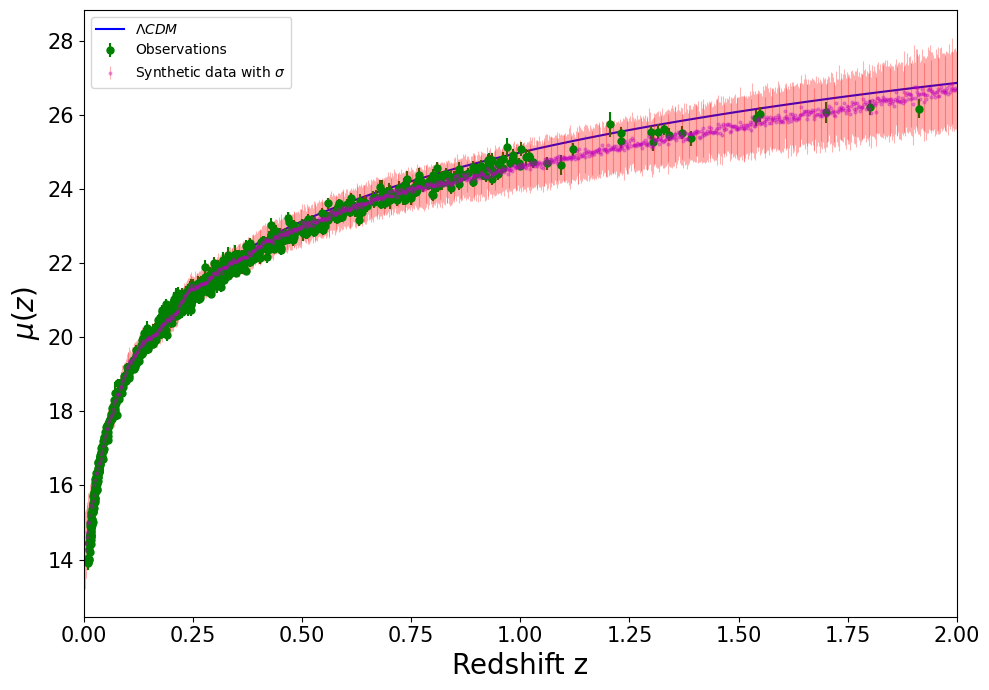

In [41]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()
plt.savefig('plots/pantheon_rec.png', dpi=100)

In [42]:
 prediction_mc_dropout[0,:]

array([14.40830663,  0.15627161])

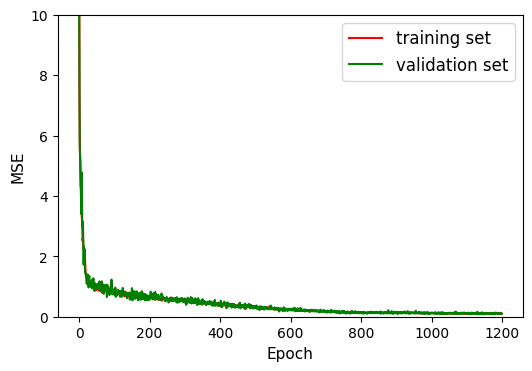

In [43]:
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0,10)
plt.savefig('plots/pantheon_loss.png', dpi=100)

In [44]:
model.save('models/Pantheon.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )